In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y %H:%M:%S')
# df = pd.read_csv("Microsoft_Stock.csv", parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = pd.read_csv("Microsoft_Stock.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
for i in df.columns:
    print("The number of NaA in {} is {}".format(i, df[i].isnull().sum()))

The number of NaA in Date is 0
The number of NaA in Open is 0
The number of NaA in High is 0
The number of NaA in Low is 0
The number of NaA in Close is 0
The number of NaA in Volume is 0


In [5]:
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %H:%M:%S')

In [6]:
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %H:%M:%S').dt.normalize()

In [7]:
df.index = df.Date

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 to 2021-03-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1511 non-null   datetime64[ns]
 1   Open    1511 non-null   float64       
 2   High    1511 non-null   float64       
 3   Low     1511 non-null   float64       
 4   Close   1511 non-null   float64       
 5   Volume  1511 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.6 KB


In [9]:
df.shape

(1511, 6)

In [10]:
df.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2015-04-01,2015-04-01,40.60,40.76,40.31,40.72,36865322
2015-04-02,2015-04-02,40.66,40.74,40.12,40.29,37487476
2015-04-06,2015-04-06,40.34,41.78,40.18,41.55,39223692
2015-04-07,2015-04-07,41.61,41.91,41.31,41.53,28809375
2015-04-08,2015-04-08,41.48,41.69,41.04,41.42,24753438


In [11]:
train = df.iloc[:-378]
test = df.iloc[-378:]

## Predict "Close"

In [12]:
ts_close = train.Volume
ts_close_test = test.Volume

In [13]:
# check the stationary of data
ts_adf = ADF(ts_close.tolist())
ts_adf

(-7.106739613356577,
 4.035404999463793e-10,
 8,
 1124,
 {'1%': -3.4361812251221555,
  '5%': -2.864114820815637,
  '10%': -2.5681409066817795},
 39044.09656321539)

In [14]:
# ts_close_diff1 = ts_close.diff(1)
# ts_close_diff1 = ts_close_diff1.fillna(0)
# ts_adf_diff1 = ADF(ts_close_diff1.tolist())
# ts_adf_diff1

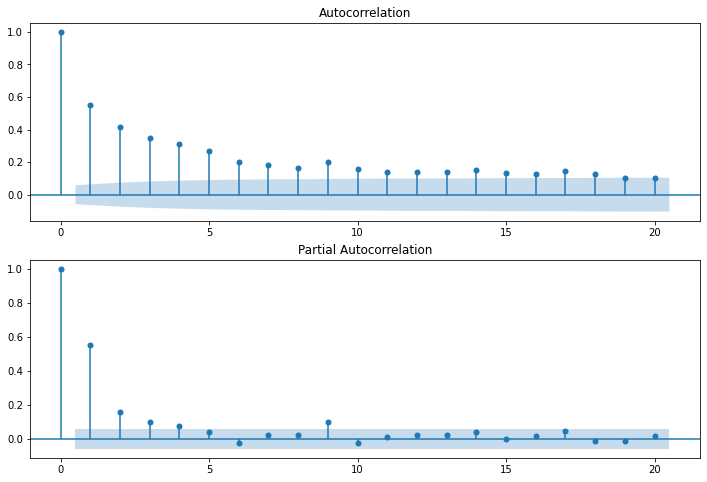

In [15]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(ts_close, lags=20, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(ts_close, lags=20, ax=ax2) 
plt.show()

In [16]:
train_results = sm.tsa.arma_order_select_ic(ts_close, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 4)
BIC (2, 2)


In [17]:
## AR(p=2)
model = sm.tsa.ARIMA(ts_close, order=(2, 0, 2))
model_fit = model.fit()

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76279D+01    |proj g|=  8.01492D-04

At iterate    5    f=  1.76279D+01    |proj g|=  1.81188D-05

At iterate   10    f=  1.76279D+01    |proj g|=  5.68434D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     27      1     0     0   3.553D-07   1.763D+01
  F =   17.627892741491504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


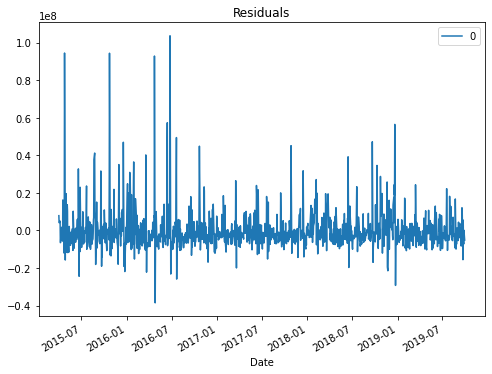

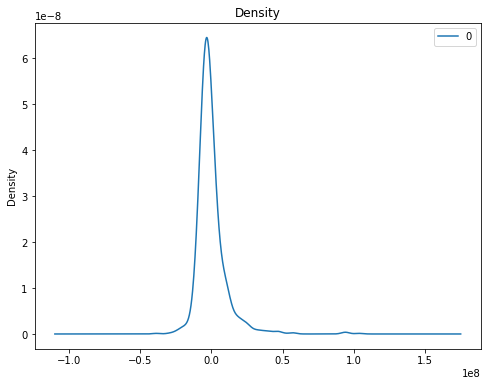

In [18]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
fig1, ax1 = plt.subplots(figsize=(8,6))
residuals.plot(title="Residuals", ax=ax1)
fig2, ax2 = plt.subplots(figsize=(8,6))
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

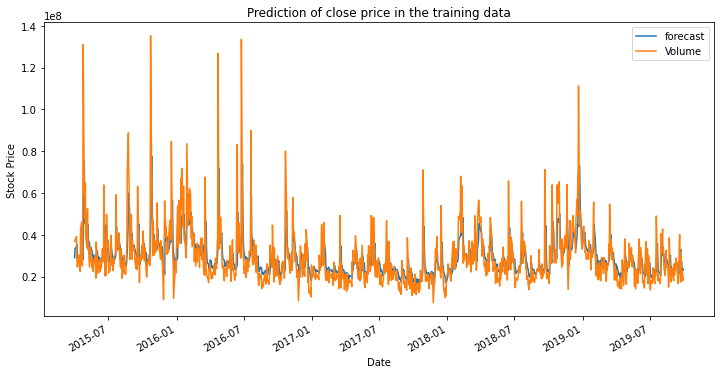

In [19]:
fig3, ax3 = plt.subplots(figsize=(12,6))
model_fit.plot_predict(dynamic=False, ax=ax3)
plt.ylabel("Stock Price")
plt.title("Prediction of close price in the training data")
plt.show()

In [20]:
predict = model_fit.forecast(steps=378, alpha=0.05)[0]

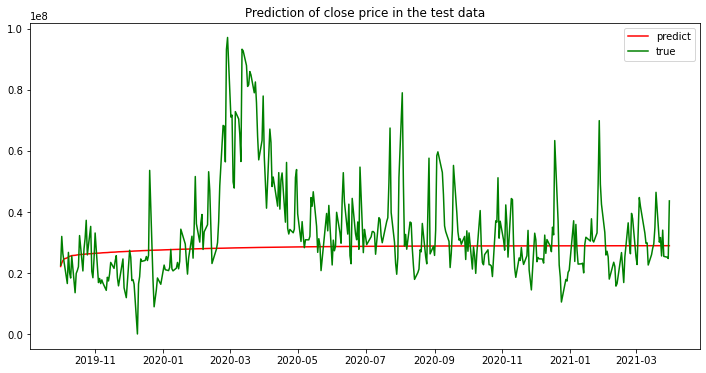

In [21]:
plt.figure(figsize=(12,6))
plt.plot(ts_close_test.index, predict, label='predict', color='red')
plt.plot(ts_close_test.index, ts_close_test.values, label='true', color='green')
plt.legend()
plt.title("Prediction of close price in the test data")
plt.show()

In [179]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.seasonal import STL

In [180]:
# result = STL(ts_close, period=12).fit()
# result.plot()
# plt.show()

In [25]:
pd.DataFrame(predict).to_csv("../output/Stock_close_arima.csv", index=False)